#### Your name:

<pre> Isaac Aktam</pre>

### Collaborators:

<pre> Ashish Gupta, Konrad Korzeniewski</pre>

In [234]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


### Classification - Based on Week 3

Q1. Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In week 3, you:
- Explored the dataset
- Built a full data pipeline
- Pre-processed data, explored features

Building on your work of week 3:
- Split dataset into 3 sets:
  - 70% -> Training and cross validation
  - 15% -> Model Stacking
  - 15% -> Testing
  

- Tune a decision tree classfier:
  - select a score (http://scikit-learn.org/stable/modules/model_evaluation.html). Explain your choice 
  - tune one parameter a time. Generate a plot for the score vs parameter values. Analyze your results.
    - criterion, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes=None    
  - tune all parameters at the same time using a randomgrid(http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). First, run with a coarse grid, then refine in the next iteration. Use the information from the previous step to select parameter values.
  

For this assignment, we choose the ROC-AUC as a score measure because:

 - AUC applies to binary classifiers
 - We want to choose hyperparameters with the highest AUC score so that we have a greater True Positives and a lower number of False Positives. Note: higher AUC score does not necessary lead to a higher accuracy score as can be seen in a case of a such hyperparameter as min_samples_split; therefore, we would need to sacrifice some AUC score for the accuracy score.
 - Lastly, we use the AUC score since we are dealing with the same dataset/business problem as in A3.
 
For the sake of simplicity we are not changing the Threshold. Therefore, the default Threshold is 0.5.
Therefore, we choose the hyperparameter values that lead to high AUC scores and high accuracy rates. If, a hyperparameter has a high a AUC score but a low accuracy score, we change the value of hyperparameters so that AUC score decreases and accuracy score increases.

In [235]:
### Your code here

## Feel free to use multiple cells

df = pd.read_excel("/home/isaac/Fundamentals_of_Data_Science_Certificate/3253 - Machine_Learning/Assignments/default of credit card clients.xls", 
                   sheet = 0, skiprows= 1, header = 0)

In [236]:
# Remove the ID Column as we don't need it for any analysis

df = df.drop('ID', axis=1)

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

Note that the Decision Trees do not require the data to be standardized or scaled.

Building on your work of week 3:
- Split dataset into 3 sets:
  - 70% -> Training and cross validation
  - 15% -> Model Stacking
  - 15% -> Testing
  

In [238]:
# Need to do splitting twice

# Stratified sampling

# First split, get the Training Set and the Set to be Split Twice (sounds like a tile of a really cool movie)
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 123)
for train_index, split_twice_index in split.split(df, df["default payment next month"]):
    strat_train_set = df.loc[train_index]
    strat_split_twice_set = df.loc[split_twice_index]
    
# Second split
second_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 123)
for stack_index, test_index in second_split.split(strat_split_twice_set, strat_split_twice_set["default payment next month"]):
    strat_stack_set = df.loc[stack_index]
    strat_test_set = df.loc[test_index]

In [239]:
# Divide the datasets into x and y

# Now, let's revert to a clean data set (by copying strat_train_set once again), and let's separate predictors and 
# let's separate the predictors and the labels since we don't necessarily want to apply the same transformations
# to the predictors and the target values (note that drop() creates a copy of the data and does not affect
# strat_train_set)

# Train
df_train_x = strat_train_set.drop("default payment next month", axis = 1)
df_train_y = strat_train_set["default payment next month"].copy()

# Stack
df_stack_x = strat_stack_set.drop("default payment next month", axis = 1)
df_stack_y = strat_stack_set["default payment next month"].copy()

# Test
df_test_x = strat_test_set.drop("default payment next month", axis = 1)
df_test_y = strat_test_set["default payment next month"].copy()

In [240]:
print(strat_train_set.shape[0] / df.shape[0])
print(strat_stack_set.shape[0] / df.shape[0])
print(strat_test_set.shape[0] / df.shape[0])

0.7
0.15
0.15


In [241]:
# Let's see if this worked as expected. Let's look at the "default payment next month" proportions in full credit
# dataset

print(df["default payment next month"].value_counts() / len(df))
print(strat_train_set["default payment next month"].value_counts() / len(strat_train_set))
print(strat_stack_set["default payment next month"].value_counts() / len(strat_stack_set))
print(strat_test_set["default payment next month"].value_counts() / len(strat_test_set))

# Proportions are nearly the same, therefore it works out.

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64
0    0.77881
1    0.22119
Name: default payment next month, dtype: float64
0    0.774889
1    0.225111
Name: default payment next month, dtype: float64
0    0.776222
1    0.223778
Name: default payment next month, dtype: float64


- Tune a decision tree classfier:
  - select a score (http://scikit-learn.org/stable/modules/model_evaluation.html). Explain your choice 
  - tune one parameter a time. Generate a plot for the score vs parameter values. Analyze your results.
    - criterion, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes=None    
  - tune all parameters at the same time using a randomgrid(http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). First, run with a coarse grid, then refine in the next iteration. Use the information from the previous step to select parameter values.
  

In [242]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [243]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

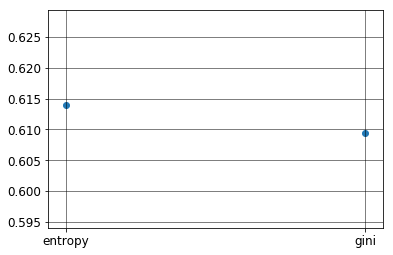

{'criterion': 'entropy'}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [244]:
criterion_estimators_1 = ['gini', 'entropy']

list_of_auc_1 = []

### CROSS VALIDATION TO GET THE AUC CURVES

for parameter in criterion_estimators_1:
    tree_clf_cv = DecisionTreeClassifier(criterion = parameter, random_state = 42)
    tree_clf_cv.fit(df_train_x, df_train_y)
    
    # Next, get the scores
    # This gives us the continuous predictions
    df_labels_probas_trees = cross_val_predict(tree_clf_cv, df_train_x, df_train_y, cv = 4,
                                        method = "predict_proba")
    # But, to plot ROC curve, you need scores, not probabilities. A simple solution is to use the positive class's
    # probability as the score

    df_scores_trees = df_labels_probas_trees[:, 1]
    
    roc_auc_trees = roc_auc_score(df_train_y, df_scores_trees)

    list_of_auc_1.append(roc_auc_trees)

    
### PLOT THE AUC SCORES VS. THE PARAMETERS

plt.figure()
x_axis_1 = criterion_estimators_1
plt.scatter(x_axis_1, list_of_auc_1)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### GRID SEARCH

param_grid_forest_1 = {'criterion' : criterion_estimators_1}

grid_search_1 = GridSearchCV(tree_clf, param_grid_forest_1, cv = 4, scoring='roc_auc', refit = True)

grid_search_1.fit(df_train_x, df_train_y)

tree_best_params_1 = grid_search_1.best_params_

tree_best_estimators_1 = grid_search_1.best_estimator_

print(tree_best_params_1)

print(tree_best_estimators_1)

In [245]:
print(tree_best_estimators_1.score(df_train_x, df_train_y))

# Let's get the accuracy score

print(accuracy_score(df_train_y, tree_best_estimators_1.predict(df_train_x)))

0.9994761904761905
0.9994761904761905


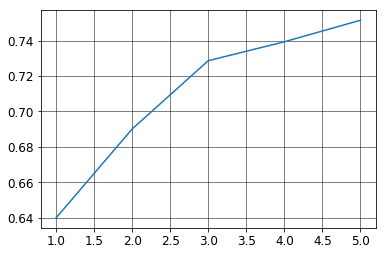

{'max_depth': 5}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [246]:
criterion_estimators_2 = [1, 2, 3, 4, 5] # Note, the reason why we don't go beyond 5 is that AUC starts decreasing
                                         # and the GridSearchCV keeps choosing the highest possible max_depth
                                         # eventhough AUC keeps decreasing. Same goes for min_samples_split

list_of_auc_2 = []

### CROSS VALIDATION TO GET THE AUC CURVES

for depth in criterion_estimators_2:
    tree_clf_cv = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    tree_clf_cv.fit(df_train_x, df_train_y)
    
    # Next, get the scores
    # This gives us the continuous predictions
    df_labels_probas_trees = cross_val_predict(tree_clf_cv, df_train_x, df_train_y, cv = 4,
                                        method = "predict_proba")
    # But, to plot ROC curve, you need scores, not probabilities. A simple solution is to use the positive class's
    # probability as the score

    df_scores_trees = df_labels_probas_trees[:, 1]
    
    roc_auc_trees = roc_auc_score(df_train_y, df_scores_trees)

    list_of_auc_2.append(roc_auc_trees)

    
### PLOT THE AUC SCORES VS. THE PARAMETERS

plt.figure()
x_axis_2 = criterion_estimators_2
plt.plot(x_axis_2, list_of_auc_2)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### GRID SEARCH

param_grid_forest_2 = {'max_depth' : criterion_estimators_2}

grid_search_2 = GridSearchCV(tree_clf, param_grid_forest_2, cv = 4, scoring='roc_auc', refit = True)

grid_search_2.fit(df_train_x, df_train_y)

tree_best_params_2 = grid_search_2.best_params_

tree_best_estimators_2 = grid_search_2.best_estimator_

print(tree_best_params_2)

print(tree_best_estimators_2)

In [247]:
tree_best_estimators_2.score(df_train_x, df_train_y)

0.8232857142857143

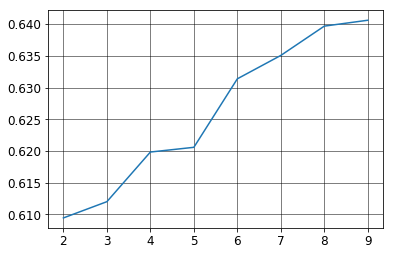

{'min_samples_split': 9}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [248]:
criterion_estimators_3 = list(range(2, 10))

list_of_auc_3 = []

for splits in criterion_estimators_3:
    tree_clf_cv = DecisionTreeClassifier(min_samples_split = splits, random_state = 42)
    tree_clf_cv.fit(df_train_x, df_train_y)
    
    # Next, get the scores
    # This gives us the continuous predictions
    df_labels_probas_trees = cross_val_predict(tree_clf_cv, df_train_x, df_train_y, cv = 4,
                                        method = "predict_proba")
    # But, to plot ROC curve, you need scores, not probabilities. A simple solution is to use the positive class's
    # probability as the score

    df_scores_trees = df_labels_probas_trees[:, 1]
    
    roc_auc_trees = roc_auc_score(df_train_y, df_scores_trees)

    list_of_auc_3.append(roc_auc_trees)

    
### PLOT THE AUC SCORES VS. THE PARAMETERS

plt.figure()
x_axis_3 = criterion_estimators_3
plt.plot(x_axis_3, list_of_auc_3)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### GRID SEARCH

param_grid_forest_3 = {'min_samples_split' : criterion_estimators_3} # Do we need an early stopping here since
                                                                     # our AUC keeps increasing as the number of
                                                                     # min_samples_split increases

grid_search_3 = GridSearchCV(tree_clf, param_grid_forest_3, cv = 4, scoring='roc_auc', refit = True)

grid_search_3.fit(df_train_x, df_train_y)

tree_best_params_3 = grid_search_3.best_params_

tree_best_estimators_3 = grid_search_3.best_estimator_

print(tree_best_params_3)

print(tree_best_estimators_3)

In [249]:
tree_best_estimators_3.score(df_train_x, df_train_y)

0.9410952380952381

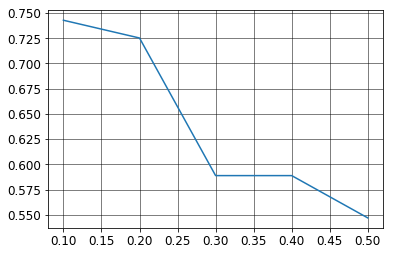

{'min_samples_leaf': 0.1}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [250]:
criterion_estimators_4 = [(i + 1) / 10 for i in range(5)]

list_of_auc_4 = []

for leaf_samples in criterion_estimators_4:
    tree_clf_cv = DecisionTreeClassifier(min_samples_leaf = leaf_samples, random_state = 42)
    tree_clf_cv.fit(df_train_x, df_train_y)
    
    # Next, get the scores
    # This gives us the continuous predictions
    df_labels_probas_trees = cross_val_predict(tree_clf_cv, df_train_x, df_train_y, cv = 4,
                                        method = "predict_proba")
    # But, to plot ROC curve, you need scores, not probabilities. A simple solution is to use the positive class's
    # probability as the score

    df_scores_trees = df_labels_probas_trees[:, 1]
    
    roc_auc_trees = roc_auc_score(df_train_y, df_scores_trees)

    list_of_auc_4.append(roc_auc_trees)

    
### PLOT THE AUC SCORES VS. THE PARAMETERS

plt.figure()
x_axis_4 = criterion_estimators_4
plt.plot(x_axis_4, list_of_auc_4)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### GRID SEARCH

param_grid_forest_4 = {'min_samples_leaf' : criterion_estimators_4}

grid_search_4 = GridSearchCV(tree_clf, param_grid_forest_4, cv = 4, scoring='roc_auc', refit = True)

grid_search_4.fit(df_train_x, df_train_y)

tree_best_params_4 = grid_search_4.best_params_

tree_best_estimators_4 = grid_search_4.best_estimator_

print(tree_best_params_4)

print(tree_best_estimators_4)

In [251]:
tree_best_estimators_4.score(df_train_x, df_train_y)

0.818

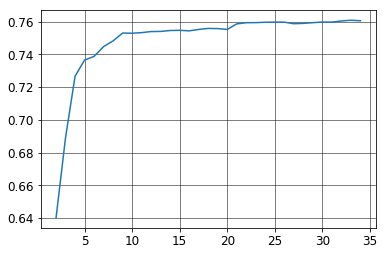

{'max_leaf_nodes': 33}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=33,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [252]:
criterion_estimators_5 = list(range(2, 35))

list_of_auc_5 = []

for max_leaf_node in criterion_estimators_5:
    tree_clf_cv = DecisionTreeClassifier(max_leaf_nodes = max_leaf_node, random_state = 42)
    tree_clf_cv.fit(df_train_x, df_train_y)
    
    # Next, get the scores
    # This gives us the continuous predictions
    df_labels_probas_trees = cross_val_predict(tree_clf_cv, df_train_x, df_train_y, cv = 4,
                                        method = "predict_proba")
    # But, to plot ROC curve, you need scores, not probabilities. A simple solution is to use the positive class's
    # probability as the score

    df_scores_trees = df_labels_probas_trees[:, 1]
    
    roc_auc_trees = roc_auc_score(df_train_y, df_scores_trees)

    list_of_auc_5.append(roc_auc_trees)

    
### PLOT THE AUC SCORES VS. THE PARAMETERS

plt.figure()
x_axis_5 = criterion_estimators_5
plt.plot(x_axis_5, list_of_auc_5)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### GRID SEARCH

param_grid_forest_5 = {'max_leaf_nodes' : criterion_estimators_5}

grid_search_5 = GridSearchCV(tree_clf, param_grid_forest_5, cv = 4, scoring='roc_auc', refit = True)

grid_search_5.fit(df_train_x, df_train_y)

tree_best_params_5 = grid_search_5.best_params_

tree_best_estimators_5 = grid_search_5.best_estimator_

print(tree_best_params_5)

print(tree_best_estimators_5)

In [253]:
tree_best_estimators_5.score(df_train_x, df_train_y)

0.8228571428571428

Tune all parameters at the same time using a randomgrid(http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). First, run with a coarse grid, then refine in the next iteration. Use the information from the previous step to select parameter values.

In [254]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [255]:
param_distributions = {'criterion' : criterion_estimators_1, 'max_depth' : criterion_estimators_2,
                      'min_samples_split' : criterion_estimators_3, 'min_samples_leaf' : criterion_estimators_4,
                      'max_leaf_nodes' : criterion_estimators_5}
rnd_search_cv = RandomizedSearchCV(tree_clf, param_distributions, n_iter=10, verbose=2)
rnd_search_cv.fit(df_train_x, df_train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] min_samples_split=8, min_samples_leaf=0.3, max_leaf_nodes=25, max_depth=3, criterion=gini 
[CV]  min_samples_split=8, min_samples_leaf=0.3, max_leaf_nodes=25, max_depth=3, criterion=gini, total=   0.0s
[CV] min_samples_split=8, min_samples_leaf=0.3, max_leaf_nodes=25, max_depth=3, criterion=gini 
[CV]  min_samples_split=8, min_samples_leaf=0.3, max_leaf_nodes=25, max_depth=3, criterion=gini, total=   0.0s
[CV] min_samples_split=8, min_samples_leaf=0.3, max_leaf_nodes=25, max_depth=3, criterion=gini 
[CV]  min_samples_split=8, min_samples_leaf=0.3, max_leaf_nodes=25, max_depth=3, criterion=gini, total=   0.0s
[CV] min_samples_split=8, min_samples_leaf=0.1, max_leaf_nodes=29, max_depth=4, criterion=entropy 
[CV]  min_samples_split=8, min_samples_leaf=0.1, max_leaf_nodes=29, max_depth=4, criterion=entropy, total=   0.1s
[CV] min_samples_split=8, min_samples_leaf=0.1, max_leaf_nodes=29, max_depth=4, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  min_samples_split=8, min_samples_leaf=0.1, max_leaf_nodes=29, max_depth=4, criterion=entropy, total=   0.1s
[CV] min_samples_split=8, min_samples_leaf=0.1, max_leaf_nodes=29, max_depth=4, criterion=entropy 
[CV]  min_samples_split=8, min_samples_leaf=0.1, max_leaf_nodes=29, max_depth=4, criterion=entropy, total=   0.1s
[CV] min_samples_split=4, min_samples_leaf=0.4, max_leaf_nodes=2, max_depth=2, criterion=gini 
[CV]  min_samples_split=4, min_samples_leaf=0.4, max_leaf_nodes=2, max_depth=2, criterion=gini, total=   0.0s
[CV] min_samples_split=4, min_samples_leaf=0.4, max_leaf_nodes=2, max_depth=2, criterion=gini 
[CV]  min_samples_split=4, min_samples_leaf=0.4, max_leaf_nodes=2, max_depth=2, criterion=gini, total=   0.0s
[CV] min_samples_split=4, min_samples_leaf=0.4, max_leaf_nodes=2, max_depth=2, criterion=gini 
[CV]  min_samples_split=4, min_samples_leaf=0.4, max_leaf_nodes=2, max_depth=2, criterion=gini, total=   0.0s
[CV] min_samples_split=6, min_samples_leaf=0.2, max_leaf_n

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [256]:
rnd_search_cv.score(df_train_x, df_train_y)

0.818

In [257]:
rnd_search_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_leaf_nodes': 29,
 'min_samples_leaf': 0.1,
 'min_samples_split': 8}

In [258]:
# Let's choose the best model and work with the test set

final_model_tree = tree_best_estimators_1

y_te_estimation_tree = final_model_tree.predict(df_test_x)

print(accuracy_score(df_test_y, y_te_estimation_tree))

0.9188888888888889


Taking A3 into reference, the Recall score was 36% and threshold was adjusted to increases the recall to 76%. Since we are not adjusting threshold in this assignment, we still continue our analysis with a lower recall thus resulting in lower True Positives and higher True Negatives.

Since the accuracy on the training set is 99% and the accuracy on the test set is 91%, Logistic Regression underfits the data eventhough it has the highest accuracy rate.

### Ensemble Learning

Make sure to read and understand the documentation for each classifier.

Remember to make your code modular; it will save you rewriting the same things multiple times and will help avoid copy paste errors.


  
- Tune the following classifiers:
  - Random forest classfier
  - Adaboost Tree classifier
  - Extra trees classifier
  - Gradient Boosted Tree classifier
  - Logistic Regression
  
- Analyze, compare, and interpret your results
- What ensemble yields the best result? Can you identify certain types of events that are classified better/worse from the type of algorithm?
- Is the feature importance consistent for all classifiers?

In [259]:
# Let's standardize the data

# Standardization of non-categorical data only, so, do not clean such data as Bill_Amt_i, education, Pay, Sex

df_num = df_train_x.drop(["MARRIAGE", "SEX", "EDUCATION", "PAY_0", "PAY_2", "PAY_3", 
                          "PAY_4", "PAY_5", "PAY_6", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4",
                         "BILL_AMT5", "BILL_AMT6"], axis = 1)



cat_attribs = ["MARRIAGE", "SEX", "EDUCATION", "PAY_0", "PAY_2", "PAY_3", "PAY_4", 
                                  "PAY_5", "PAY_6", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", 
                                  "BILL_AMT5", "BILL_AMT6"]


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

# There is nothing in Scikit-Learn to handle Pandas DataFrames, so we need to write a custom transformer for this
# task

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

# FROM HERE

num_attribs = list(df_num)
#dropped_attributes = list(dropped_attributes)

num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                         ('std_scaler', StandardScaler())])


cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs))])

full_pipeline = FeatureUnion([("num_pipeline", num_pipeline), 
                              ("cat_pipeline", cat_pipeline)])



df_train_x = full_pipeline.fit_transform(df_train_x)
# TO HEREd

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [445]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [426]:
# Random Forest Classifier

n_estimators = [10, 200]
max_features = [0.1, 0.5]
max_depth = [2, 10, 20] 
oob_score = [True, False]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5] # Interestingly, when this hyperparameter is used, accuracy on the train and test sets
                              # is the same.
max_leaf_nodes = [2, 10, 100]

param_grid_forest = {'n_estimators' : n_estimators, 'max_features' : max_features,
                     'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                    'oob_score' : oob_score, 'min_samples_leaf': min_samples_leaf, 
                     'max_leaf_nodes' : max_leaf_nodes}

forest_class = RandomForestClassifier(random_state = 42)

grid_search_forest = GridSearchCV(forest_class, param_grid_forest, cv = 4, scoring='roc_auc', refit = True,
                                 n_jobs = -1)

grid_search_forest.fit(df_train_x, df_train_y)

forest_best_params_ = grid_search_forest.best_params_

forest_best_estimators_ = grid_search_forest.best_estimator_

print(forest_best_params_)

print(forest_best_estimators_)

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do no

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute an

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do no

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute an

{'max_depth': 10, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 200, 'oob_score': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=0.5, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)


In [427]:
final_model_forest = forest_best_estimators_

y_st_estimation_forest = final_model_forest.predict(full_pipeline.fit_transform(df_stack_x))

print(accuracy_score(df_stack_y, y_st_estimation_forest))

0.7748888888888888


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [428]:
# Test on the Test Data

y_te_estimation_forest = final_model_forest.predict(full_pipeline.transform(df_test_x))

print(accuracy_score(df_test_y, y_te_estimation_forest))

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.7762222222222223


In [429]:
print(accuracy_score(df_stack_y, y_st_estimation_forest) - accuracy_score(df_test_y, y_te_estimation_forest))

-0.0013333333333334085


Random Forest Classifier fits the data well since test set accuracy and stack set accuracy are nearly the same.

In [430]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import itertools

# For the purposes of this assignment, we want high recall and low precision.

In [432]:
# Confusion matrix

print(confusion_matrix(df_stack_y, y_st_estimation_forest))

print("Precision: ", precision_score(df_stack_y, y_st_estimation_forest))

print("Recall: ", recall_score(df_stack_y, y_st_estimation_forest))

[[3487    0]
 [1013    0]]
Precision:  0.0
Recall:  0.0


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3487 True Negatives, 1013 False Negatives. 0 True Positives and False Positives. Both Recall and Precision are zero which is pretty terrible.

In [405]:
# Feature importance

pear = sorted(zip(grid_search_forest.best_estimator_.feature_importances_, list(df_stack_x)), reverse = True)
pear

[(0.3955190981725558, 'BILL_AMT1'),
 (0.2115703197498705, 'EDUCATION'),
 (0.19295769850612324, 'LIMIT_BAL'),
 (0.10073341791198995, 'MARRIAGE'),
 (0.05091084406255265, 'AGE'),
 (0.009111532778054304, 'PAY_0'),
 (0.006526377521975554, 'PAY_3'),
 (0.005878097640847394, 'PAY_AMT1'),
 (0.0052800177962713845, 'PAY_AMT2'),
 (0.004464717073894383, 'PAY_2'),
 (0.003995083611835989, 'BILL_AMT3'),
 (0.003335805173495477, 'PAY_AMT3'),
 (0.003328197614999343, 'PAY_AMT5'),
 (0.0026406482508088748, 'PAY_AMT6'),
 (0.0018310758027906848, 'BILL_AMT4'),
 (0.0013470962974559924, 'PAY_AMT4'),
 (0.00046070045880206213, 'BILL_AMT6'),
 (5.3527859670629135e-05, 'PAY_6'),
 (4.605609745889326e-05, 'SEX'),
 (9.687618546874506e-06, 'PAY_4'),
 (0.0, 'PAY_5'),
 (0.0, 'BILL_AMT5'),
 (0.0, 'BILL_AMT2')]

In [313]:
import matplotlib.pyplot as plt

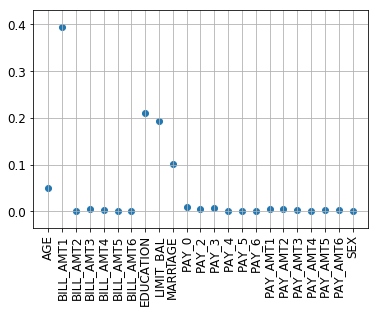

In [322]:
x = list(df_stack_x)
y = grid_search_forest.best_estimator_.feature_importances_

plt.figure()
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.grid()
plt.show()

As we can see from above, the most important features seem to be 'BILL_AMT1', 'EDUCATION', 'LIMIT_BAL', 'MARRIAGE', and 'AGE'. The rest can be dropped.

In [265]:
# Ada Boost Classifier

n_estimators = [3, 20, 50, 100, 200]
learning_rate = [0.1, 0.5, 0.9]
algorithm = ['SAMME', 'SAMME.R']

ada_class = AdaBoostClassifier(random_state = 42)

param_grid_ada = {'n_estimators' : n_estimators, 'learning_rate' : learning_rate, 'algorithm' : algorithm}
#param_grid_ada = {'n_estimators' : n_estimators}

grid_search_ada = GridSearchCV(ada_class, param_grid_ada, cv = 4, scoring='roc_auc', refit = True, n_jobs = -1, verbose = 2)

grid_search_ada.fit(df_train_x, df_train_y)

ada_best_params_ = grid_search_ada.best_params_

ada_best_estimators_ = grid_search_ada.best_estimator_

print(ada_best_params_)

print(ada_best_estimators_)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=3 ..............
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=3 ..............
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=3 ..............
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=3 ..............
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=3, total=   0.1s
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=20 .............
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=3, total=   0.2s
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=3, total=   0.1s
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=20 .............
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=20 .............
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=3, total=   0.2s
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=20 .............
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=20, total=   0.8s
[CV]  alg

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.6s


[CV]  algorithm=SAMME, learning_rate=0.5, n_estimators=100, total=   3.9s
[CV] algorithm=SAMME, learning_rate=0.5, n_estimators=200 ............
[CV]  algorithm=SAMME, learning_rate=0.5, n_estimators=200, total=   7.3s
[CV] algorithm=SAMME, learning_rate=0.9, n_estimators=3 ..............
[CV]  algorithm=SAMME, learning_rate=0.5, n_estimators=200, total=   7.3s
[CV] algorithm=SAMME, learning_rate=0.9, n_estimators=3 ..............
[CV]  algorithm=SAMME, learning_rate=0.9, n_estimators=3, total=   0.2s
[CV]  algorithm=SAMME, learning_rate=0.9, n_estimators=3, total=   0.1s
[CV] algorithm=SAMME, learning_rate=0.9, n_estimators=3 ..............
[CV] algorithm=SAMME, learning_rate=0.9, n_estimators=3 ..............
[CV]  algorithm=SAMME, learning_rate=0.5, n_estimators=200, total=   7.3s
[CV]  algorithm=SAMME, learning_rate=0.5, n_estimators=200, total=   7.6s
[CV] algorithm=SAMME, learning_rate=0.9, n_estimators=20 .............
[CV] algorithm=SAMME, learning_rate=0.9, n_estimators=20 ...

[CV] algorithm=SAMME.R, learning_rate=0.5, n_estimators=100 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=100, total=   4.0s
[CV] algorithm=SAMME.R, learning_rate=0.5, n_estimators=200 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=100, total=   4.1s
[CV] algorithm=SAMME.R, learning_rate=0.5, n_estimators=200 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=100, total=   3.9s
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=100, total=   4.0s
[CV] algorithm=SAMME.R, learning_rate=0.5, n_estimators=200 ..........
[CV] algorithm=SAMME.R, learning_rate=0.5, n_estimators=200 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=200, total=   7.9s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=3 ............
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=200, total=   7.8s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=3 ............
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_e

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.6min finished


{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 100}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=42)


In [266]:
final_model_ada = ada_best_estimators_

y_st_estimation_ada = final_model_ada.predict(full_pipeline.fit_transform(df_stack_x))

print(accuracy_score(df_stack_y, y_st_estimation_ada))

0.8084444444444444


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [267]:
y_te_estimation_ada = final_model_ada.predict(full_pipeline.transform(df_test_x))

print(accuracy_score(df_test_y, y_te_estimation_ada))

0.8031111111111111


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [268]:
print(accuracy_score(df_stack_y, y_st_estimation_ada) - accuracy_score(df_test_y, y_te_estimation_ada))

0.005333333333333301


In [325]:
# Confusion matrix

print(confusion_matrix(df_stack_y, y_st_estimation_ada))

print("Precision: ", precision_score(df_stack_y, y_st_estimation_ada))

print("Recall: ", recall_score(df_stack_y, y_st_estimation_ada))

[[3314  173]
 [ 689  324]]
Precision:  0.6519114688128773
Recall:  0.3198420533070089


Ada Boost Classifier seems to perform better both in term of higher accuracy score (80% both on train and test sets) and Recall (32% compared to 0% to that of Random Forest).

Ada Boost Classifier fits the data well since test set accuracy and stack set accuracy are nearly the same.

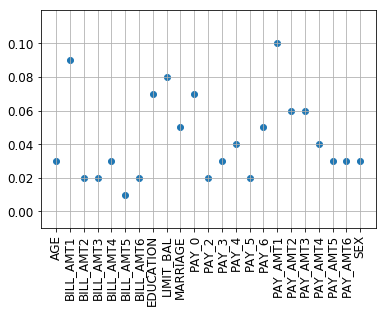

In [391]:
# Feature importance

banana = (sorted(zip(grid_search_ada.best_estimator_.feature_importances_, list(df_stack_x)), reverse = True))

x = np.array(list(df_stack_x))
y = np.array(grid_search_ada.best_estimator_.feature_importances_)

args = np.argsort(x)
x = x[args]
y = y[args]

plt.figure()
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.grid()
plt.show()

If we set our feature importance threshold at 0.05, we can see that 'PAY_AMT1', 'BILL_AMT1', 'LIMIT_BAL', 'PAY_0', 'EDUCATION', 'PAY_AMT3', 'PAY_AMT2', 'PAY_6', and 'MARRIAGE' are the most important values.

In [433]:
# Extra Trees Classifier

extra_tree_class = ExtraTreesClassifier(random_state = 42)

n_estimators = [3, 50, 100, 200]
max_features = [0.1, 0.5]
max_depth = [2, 50, 100]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5] # Mhm, this one leads to accuracy of test and train sets being the same.

#param_grid_extra_trees = {'n_estimators' : n_estimators, 'max_features' : max_features,
#                          'min_samples_leaf' : min_samples_leaf}
param_grid_extra_trees = {'n_estimators' : n_estimators, 'max_features' : max_features,
                         'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                         'min_samples_leaf' : min_samples_leaf}


grid_search_extra_trees = GridSearchCV(extra_tree_class, param_grid_extra_trees, cv = 4, scoring='roc_auc', 
                               refit = True, n_jobs = -1, verbose = 2)

grid_search_extra_trees.fit(df_train_x, df_train_y)

extra_trees_best_params_ = grid_search_extra_trees.best_params_

extra_trees_best_estimators_ = grid_search_extra_trees.best_estimator_

print(extra_trees_best_params_)

print(extra_trees_best_estimators_)

Fitting 4 folds for each of 96 candidates, totalling 384 fits
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=2,

[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50, total=   0.3s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   1.1s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=100, total=   0.6s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=100 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=100, total=   0.4s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  max_depth=2, max_features=0.1, mi

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.5s


[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, total=   1.8s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   3.4s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] max_depth=2, max_features=0.5, min_sample

[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=50, total=   0.3s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=50, total=   0.4s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   1.9s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=100 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   2.0s
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=50, total=   0.4s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=100 
[CV] max_depth=2, max_features=0.5, min

[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=100, total=   0.5s
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=100, total=   0.7s
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=100, total=   0.7s
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   1.1s
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=50, max_features=0.1, min_

[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.9s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50 
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   1.1s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   1.0s
[CV] max_depth=50, max_features=0.

[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:   40.5s


[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, total=   1.0s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, total=   1.1s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, total=   0.9s
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, total=   1.0s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100 
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, total=   1.7s
[CV] max_depth=50, max_featur

[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=100, total=   0.7s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.8s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=50, max_features=0.5, min_samples_

[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   1.2s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   1.3s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50, total=   0.3s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50, total=   0.4s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=100 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50, total=   0.3s
[CV] max_depth=100, ma

[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=100 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=100, total=   0.6s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=100, total=   0.6s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=100, total=   0.8s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=100, total=   0.8s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  max_depth=100, max_featur

[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   3.8s
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=100, max_features=0.5, min_sa

[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  1.6min finished


{'max_depth': 50, 'max_features': 0.5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 200}
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=50, max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.1, min_samples_split=0.1,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


In [434]:
final_model_extra_trees = extra_trees_best_estimators_

y_st_estimation_extra_trees = final_model_extra_trees.predict(full_pipeline.fit_transform(df_stack_x))

print(accuracy_score(df_stack_y, y_st_estimation_extra_trees))

0.7748888888888888


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [435]:
y_te_estimation_extra_trees = final_model_extra_trees.predict(full_pipeline.transform(df_test_x))

print(accuracy_score(df_stack_y, y_te_estimation_extra_trees))

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.7748888888888888


In [436]:
print(accuracy_score(df_stack_y, y_st_estimation_extra_trees) - accuracy_score(df_stack_y, y_te_estimation_extra_trees))

0.0


Extra Trees Classifier fits the data well since test set accuracy and stack set accuracy are exactly the same.

In [473]:
# Confusion matrix

print(confusion_matrix(df_stack_y, y_st_estimation_extra_trees))

print("Precision: ", precision_score(df_stack_y, y_st_estimation_extra_trees))

print("Recall: ", recall_score(df_stack_y, y_st_estimation_extra_trees))

[[3487    0]
 [1013    0]]
Precision:  0.0
Recall:  0.0


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Wow, Extra Trees Classifier is pretty terrible when it comes to classifying data since both the Precision and Recall are 0. Additionally, it misclassifies 1013 values as False Negatives and 3487 values as True Negatives. Interestingly, both Random Forest and Extra Trees classifiers have the same confusion matrix.  Interestingly, both of these classifiers have nearly the same accuracy both on the trainig and test sets.

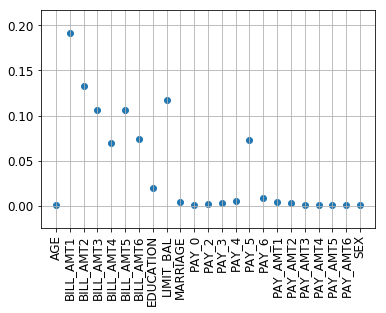

In [393]:
# Feature importance

apple = (sorted(zip(grid_search_extra_trees.best_estimator_.feature_importances_, list(df_stack_x)), reverse = True))

x = np.array(list(df_stack_x))
y = np.array(grid_search_extra_trees.best_estimator_.feature_importances_)

args = np.argsort(x)
x = x[args]
y = y[args]

plt.figure()
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.grid()
plt.show()

From the above, we can see that the most important features are 'BILL_AMT1', 'BILL_AMT2', 'LIMIT_BAL', 'BILL_AMT3', 'BILL_AMT5', 'BILL_AMT6', 'PAY_5', 'BILL_AMT4', 'EDUCATION'.

In [274]:
# Gradient Boosting Classifier

grad_boost_class = GradientBoostingClassifier(random_state = 42)

n_estimators = [3, 200]
learning_rate = [0.1, 0.5]
max_depth = [3, 50, 100]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5]
max_features = [0.1, 0.5]
max_leaf_nodes = [2, 50, 100]
                            
param_grid_grad_boost_class = {'n_estimators' : n_estimators, 'learning_rate' : learning_rate,
                              'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                              'min_samples_leaf' : min_samples_leaf, 'max_features' : max_features,
                              'max_leaf_nodes' : max_leaf_nodes}

grid_search_grad_boost_class = GridSearchCV(grad_boost_class, param_grid_grad_boost_class, cv = 4, scoring='roc_auc', 
                               refit = True, n_jobs = -1, verbose = 2)

grid_search_grad_boost_class.fit(df_train_x, df_train_y)

grad_boost_class_best_params_ = grid_search_grad_boost_class.best_params_

grad_boost_class_best_estimators_ = grid_search_grad_boost_class.best_estimator_

print(grad_boost_class_best_params_)

print(grad_boost_class_best_estimators_)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0

[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   1.2s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   2.3s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   2.0s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   10.1s


[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   3.1s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   1.9s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   2.0s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 


[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   3.2s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=

[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   5.2s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   5.3s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1

[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   2.4s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   2.1s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200,

[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.8s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3,

[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:   58.3s


[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   3.4s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   3.4s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=  10.7s
[CV] learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimato

[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  

[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.9s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200,

[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   1.8s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimato

[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.8s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimato

[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, t

[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   8.3s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 

[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=  11.9s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 


[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:  2.9min


[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   6.9s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   6.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_spli

[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.2s
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   1.8s
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimator

[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimator

[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   1.4s
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   1.7s
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   3.3s
[CV] learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=

[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.8s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=20

[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.7s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   2.2s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   2.5s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_esti

[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   7.3s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estima

[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   8.4s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.8s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5

[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   2.5s
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  lea

[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   2.7s
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  le

[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 


[Parallel(n_jobs=-1)]: Done 647 tasks      | elapsed:  4.9min


[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   3.9s
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   1.8s
[CV] learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimato

[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learnin

[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   7.0s
[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.3s
[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  

[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   3.1s
[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   3.0s
[CV] learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimator

[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=3, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=

[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   1.7s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   1.3s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   1.0s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=

[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   1.0s
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   1.6s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=

[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   2.1s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.7s
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.6s
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_e

[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   4.3s
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   4.3s
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 


[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   5.6s
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, 

[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   8.3s
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   9.2s
[CV] learning_rate=0.5, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_

[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   1.9s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, 

[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   1.3s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   1.3s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   2.6s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_

[Parallel(n_jobs=-1)]: Done 1012 tasks      | elapsed:  7.4min


[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.7s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.7s
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estim

[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   2.6s
[CV] learning_rate=0.5, max_depth=100, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.

[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.1s
[CV

[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=  11.8s
[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=  10.1s
[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   6.0s
[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, 

[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   8.2s
[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   8.2s
[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.2s
[CV] learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=100, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5

[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  8.5min finished


{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 50, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 200}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=0.5, max_leaf_nodes=50,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.1,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)


In [275]:
final_model_grad_boost_class = grad_boost_class_best_estimators_

y_st_estimation_grad_boost_class = final_model_grad_boost_class.predict(full_pipeline.fit_transform(df_stack_x))

print(accuracy_score(df_stack_y, y_st_estimation_grad_boost_class))

0.812


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [276]:
y_te_estimation_grad_boost_class = final_model_grad_boost_class.predict(full_pipeline.transform(df_test_x))

print(accuracy_score(df_stack_y, y_te_estimation_grad_boost_class))

0.7146666666666667


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [277]:
print(accuracy_score(df_stack_y, y_st_estimation_grad_boost_class) - accuracy_score(df_stack_y, y_te_estimation_grad_boost_class))

0.09733333333333338


Gradient Boost Classifier seems to overfit the data since the accuracy on the train set is higher than on the test set.

In [438]:
# Confusion matrix

print(confusion_matrix(df_stack_y, y_st_estimation_grad_boost_class))

print("Precision: ", precision_score(df_stack_y, y_st_estimation_grad_boost_class))

print("Recall: ", recall_score(df_stack_y, y_st_estimation_grad_boost_class))

[[3303  184]
 [ 662  351]]
Precision:  0.6560747663551402
Recall:  0.3464955577492596


Compared to Ada (Recall = 31%), Gradient Boost Classifier has a higher Recall rate of 35 % eventhough it has a lower accuracy both on the training and test sets. Actually, this is not bad since it has a higher True Positive classification rate. So far, both Ada and Grad are doing a pretty good job at correctly classifying data.

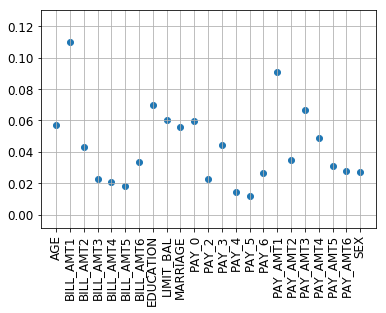

In [476]:
# Feature importance

grape = (sorted(zip(grid_search_grad_boost_class.best_estimator_.feature_importances_, list(df_stack_x)), reverse = True))

x = np.array(list(df_stack_x))
y = np.array(grid_search_grad_boost_class.best_estimator_.feature_importances_)

args = np.argsort(x)
x = x[args]
y = y[args]


plt.figure()
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [408]:
grape

[(0.11011792620556529, 'BILL_AMT1'),
 (0.09098023398083827, 'PAY_AMT1'),
 (0.06982364330219172, 'EDUCATION'),
 (0.06674942692025987, 'PAY_AMT3'),
 (0.0605896402928654, 'LIMIT_BAL'),
 (0.059584105014396364, 'PAY_0'),
 (0.05688486886892611, 'AGE'),
 (0.05614449579872767, 'MARRIAGE'),
 (0.048978019430851984, 'PAY_AMT4'),
 (0.04444150206330838, 'PAY_3'),
 (0.04295302258155109, 'BILL_AMT2'),
 (0.034927054318769225, 'PAY_AMT2'),
 (0.03352081392814138, 'BILL_AMT6'),
 (0.031098848579631955, 'PAY_AMT5'),
 (0.027912205537776912, 'PAY_AMT6'),
 (0.02732617021014294, 'SEX'),
 (0.026765601142633128, 'PAY_6'),
 (0.022677760631381428, 'BILL_AMT3'),
 (0.022514526349540227, 'PAY_2'),
 (0.021075120361714373, 'BILL_AMT4'),
 (0.018441652796054437, 'BILL_AMT5'),
 (0.014673576375820426, 'PAY_4'),
 (0.011819785308911382, 'PAY_5')]

If set the feature importance threshold at 0.05, we can see that the most important features are 'BILL_AMT1', 'PAY_AMT1', 'EDUCATION', 'PAY_AMT3', 'LIMIT_BAL', 'PAY_0', 'AGE', and 'MARRIAGE'.

In [446]:
# Logistic Regression

log_reg = LogisticRegression(random_state = 42)

C = np.array(list(range(1, 11)))/10
                            
param_grid_log_reg = {'C' : C}

grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv = 4, scoring='roc_auc', 
                               refit = True, n_jobs = -1, verbose = 2)

grid_search_log_reg.fit(df_train_x, df_train_y)

log_reg_best_params_ = grid_search_log_reg.best_params_

log_reg_best_estimators_ = grid_search_log_reg.best_estimator_

print(log_reg_best_params_)

print(log_reg_best_estimators_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.9s
[CV] C=0.2 ...........................................................
[CV] ............................................ C=0.1, total=   1.0s
[CV] C=0.2 ...........................................................
[CV] ............................................ C=0.1, total=   1.1s
[CV] ............................................ C=0.1, total=   1.1s
[CV] C=0.2 ...........................................................
[CV] C=0.2 ...........................................................
[CV] ............................................ C=0.2, total=   1.0s
[CV] ...........

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.8s


[CV] ............................................ C=0.9, total=   0.9s
[CV] ............................................ C=0.9, total=   1.3s
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] ............................................ C=0.9, total=   1.1s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   0.9s
[CV] ............................................ C=1.0, total=   0.9s
[CV] ............................................ C=1.0, total=   1.0s
[CV] ............................................ C=1.0, total=   0.7s


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.4s finished


{'C': 0.8}
LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [447]:
final_model_log_reg = log_reg_best_estimators_

y_st_estimation_log_reg = final_model_log_reg.predict(full_pipeline.fit_transform(df_stack_x))

print(accuracy_score(df_stack_y, y_st_estimation_log_reg))

0.7835555555555556


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [448]:
final_model_log_reg = log_reg_best_estimators_

y_te_estimation_log_reg = final_model_log_reg.predict(full_pipeline.transform(df_test_x))

print(accuracy_score(df_test_y, y_te_estimation_log_reg))

0.7806666666666666


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [449]:
print(accuracy_score(df_stack_y, y_st_estimation_log_reg) - accuracy_score(df_test_y, y_te_estimation_log_reg))

0.002888888888888941


Logistic Regression seems to fit the data well since the accuracy on the test is nearly identical to the one on the train set.

In [450]:
# Confusion matrix

print(confusion_matrix(df_stack_y, y_st_estimation_log_reg))

print("Precision: ", precision_score(df_stack_y, y_st_estimation_log_reg))

print("Recall: ", recall_score(df_stack_y, y_st_estimation_log_reg))

[[3454   33]
 [ 941   72]]
Precision:  0.6857142857142857
Recall:  0.07107601184600197


As we can see, Logistic Regression is pretty terrible at classifying data (3457 True Negatives and 941 False Negatives, 33 False Positives, and just 72 True Positives) eventhough it has a pretty high accuracy rate both on the training set and the test set.

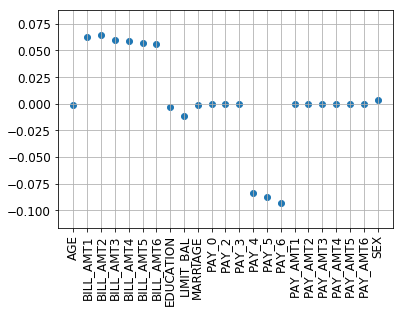

In [471]:
# Feature importance

# Since Logistic Regressiong does not "feature_importances_" method, we use "coef_" method to determine which 
# features have coefficients close or equal to 0. 

coefficients = np.array(grid_search_log_reg.best_estimator_.coef_).reshape(-1, 1)

#orange = sorted(zip(grid_search_log_reg.best_estimator_.coef_, list(df_stack_x)), reverse = True)
orange = sorted(zip(coefficients, list(df_stack_x)), reverse = True)

x = np.array(list(df_stack_x))
y = np.array(grid_search_log_reg.best_estimator_.coef_)


plt.figure()
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [472]:
orange

[(array([0.0646693]), 'BILL_AMT2'),
 (array([0.06232311]), 'BILL_AMT1'),
 (array([0.05997986]), 'BILL_AMT3'),
 (array([0.05884671]), 'BILL_AMT4'),
 (array([0.05713686]), 'BILL_AMT5'),
 (array([0.05603952]), 'BILL_AMT6'),
 (array([0.00316767]), 'SEX'),
 (array([1.52582735e-06]), 'PAY_AMT2'),
 (array([1.51362173e-08]), 'PAY_AMT4'),
 (array([-5.58635812e-07]), 'PAY_AMT6'),
 (array([-1.70915468e-06]), 'PAY_AMT3'),
 (array([-1.7436642e-06]), 'PAY_AMT5'),
 (array([-5.17567132e-06]), 'PAY_AMT1'),
 (array([-0.0002237]), 'PAY_3'),
 (array([-0.00023207]), 'PAY_0'),
 (array([-0.00057759]), 'PAY_2'),
 (array([-0.00151932]), 'AGE'),
 (array([-0.00161314]), 'MARRIAGE'),
 (array([-0.00348763]), 'EDUCATION'),
 (array([-0.01126299]), 'LIMIT_BAL'),
 (array([-0.08339902]), 'PAY_4'),
 (array([-0.08730713]), 'PAY_5'),
 (array([-0.09330416]), 'PAY_6')]

Interestingly, Logistic Regression gives us a different set of the important features compared to other 4 models. These Featues are "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "PAY_4", "PAY_5", and "PAY_6".

As we can see, Ada Boost Classifier is a clear winner when it comes to classifying and accuracy. So, from best to worst we have Ada, Grad, Log, Random Forests and Extra Trees.

Additionally, all of the five models have different feature importance; let's summarize the results:

Rand forest
'BILL_AMT1', 'EDUCATION', 'LIMIT_BAL', 'MARRIAGE', and 'AGE'

Ada
'PAY_AMT1', 'BILL_AMT1', 'LIMIT_BAL', 'PAY_0', 'EDUCATION', 'PAY_AMT3', 'PAY_AMT2', 'PAY_6', and 'MARRIAGE' 

Extra Trees
'BILL_AMT1', 'BILL_AMT2', 'LIMIT_BAL', 'BILL_AMT3', 'BILL_AMT5', 'BILL_AMT6', 'PAY_5', 'BILL_AMT4', 'EDUCATION'

Grad Boost
'BILL_AMT1', 'PAY_AMT1', 'EDUCATION', 'PAY_AMT3', 'LIMIT_BAL', 'PAY_0', 'AGE', and 'MARRIAGE'

Log Reg
"BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "PAY_4", "PAY_5", and "PAY_6"


Let's take the union of the most important features:

In [500]:
from functools import reduce

rand_for = ['BILL_AMT1', 'EDUCATION', 'LIMIT_BAL', 'MARRIAGE', 'AGE']
ada_boost = ['PAY_AMT1', 'BILL_AMT1', 'LIMIT_BAL', 'PAY_0', 'EDUCATION', 'PAY_AMT3', 'PAY_AMT2', 'PAY_6','MARRIAGE']
extra_trees = [ 'BILL_AMT1', 'BILL_AMT2', 'LIMIT_BAL', 'BILL_AMT3', 'BILL_AMT5', 'BILL_AMT6', 'PAY_5', 'BILL_AMT4', 'EDUCATION']
grad_boost = ['BILL_AMT1', 'PAY_AMT1', 'EDUCATION', 'PAY_AMT3', 'LIMIT_BAL', 'PAY_0', 'AGE', 'MARRIAGE']
log_reg = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "PAY_4", "PAY_5", "PAY_6"]

union_features = reduce(np.intersect1d, (rand_for, ada_boost, extra_trees, grad_boost, log_reg))
union_features

array(['BILL_AMT1'], dtype='<U9')

As we can see, the feature that is most important in all of the 5 models is 'BILL_AMT1'.

Let's see the feature importance for the two best models, Ada Boost and Grad Boost.

In [501]:
union_ada_grad = np.intersect1d(ada_boost, grad_boost)
union_ada_grad

array(['BILL_AMT1', 'EDUCATION', 'LIMIT_BAL', 'MARRIAGE', 'PAY_0',
       'PAY_AMT1', 'PAY_AMT3'], dtype='<U9')

As we can see, both Ada Boost and Grad Boost share the following top features 'BILL_AMT1', 'EDUCATION', 'LIMIT_BAL', 'MARRIAGE', 'PAY_0', 'PAY_AMT1', and 'PAY_AMT3'.

- Stack your models. 
  - Combine the models from the previous section using the stacking approach: 
    - Choose the model use to combine. Examples are:
      - Linear Regression
      - Logistic Regression

In [282]:
# IT IS STACKING TIME!

master_training_array = np.vstack((y_st_estimation_forest, y_st_estimation_ada, y_st_estimation_extra_trees, 
                                 y_st_estimation_grad_boost_class, y_st_estimation_log_reg))

master_training_array = master_training_array.T

In [283]:
new_log_reg = LogisticRegression(random_state = 42)

C = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
penalty = ['l1', 'l2']
tol = [0.1, 0.5]
                            
param_grid_log_reg = {'C' : C, 'penalty' : penalty, 'tol' : tol}

grid_search_log_reg = GridSearchCV(new_log_reg, param_grid_log_reg, cv = 4, scoring='roc_auc', 
                               refit = True, n_jobs = -1, verbose = 2)

grid_search_log_reg.fit(master_training_array, df_stack_y)

log_reg_best_params_ = grid_search_log_reg.best_params_

log_reg_best_estimators_ = grid_search_log_reg.best_estimator_

print(log_reg_best_params_)

print(log_reg_best_estimators_)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] C=0.0001, penalty=l1, tol=0.1 ...................................
[CV] C=0.0001, penalty=l1, tol=0.1 ...................................
[CV] C=0.0001, penalty=l1, tol=0.1 ...................................
[CV] C=0.0001, penalty=l1, tol=0.1 ...................................
[CV] .................... C=0.0001, penalty=l1, tol=0.1, total=   0.0s
[CV] C=0.0001, penalty=l1, tol=0.5 ...................................
[CV] .................... C=0.0001, penalty=l1, tol=0.5, total=   0.0s
[CV] .................... C=0.0001, penalty=l1, tol=0.1, total=   0.0s
[CV] C=0.0001, penalty=l1, tol=0.5 ...................................
[CV] .................... C=0.0001, penalty=l1, tol=0.1, total=   0.0s
[CV] .................... C=0.0001, penalty=l1, tol=0.1, total=   0.0s
[CV] C=0.0001, penalty=l1, tol=0.5 ...................................
[CV] C=0.0001, penalty=l1, tol=0.5 ...................................
[CV] ...........

[CV] C=0.1, penalty=l2, tol=0.5 ......................................
[CV] ....................... C=0.1, penalty=l1, tol=0.5, total=   0.0s
[CV] C=0.1, penalty=l1, tol=0.5 ......................................
[CV] ....................... C=0.2, penalty=l1, tol=0.1, total=   0.0s
[CV] ....................... C=0.1, penalty=l2, tol=0.5, total=   0.0s
[CV] C=0.1, penalty=l2, tol=0.5 ......................................
[CV] ...................... C=0.01, penalty=l2, tol=0.5, total=   0.1s
[CV] ....................... C=0.1, penalty=l1, tol=0.5, total=   0.0s
[CV] C=0.1, penalty=l1, tol=0.5 ......................................
[CV] C=0.1, penalty=l1, tol=0.1 ......................................
[CV] ....................... C=0.1, penalty=l2, tol=0.5, total=   0.0s
[CV] C=0.2, penalty=l1, tol=0.1 ......................................
[CV] ....................... C=0.1, penalty=l1, tol=0.5, total=   0.0s
[CV] C=0.2, penalty=l1, tol=0.5 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    2.3s finished


In [284]:
final_model_log_reg = log_reg_best_estimators_

y_st_estimation_log_reg = final_model_log_reg.predict(master_training_array)

print(accuracy_score(df_stack_y, y_st_estimation_log_reg))

0.7748888888888888


In [285]:
y_te_estimation_log_reg = final_model_log_reg.predict(master_training_array)

print(accuracy_score(df_test_y, y_te_estimation_log_reg))

0.7762222222222223


In [286]:
print(accuracy_score(df_stack_y, y_st_estimation_log_reg) - accuracy_score(df_test_y, y_te_estimation_log_reg))

-0.0013333333333334085


Compared to the original accuracy on the test set, the accuracy when Stacking is used stays nearly the same.

In [287]:
# Let's try AdaBoostClassifier

n_estimators = [3, 20, 50, 100, 200]
learning_rate = [0.1, 0.5, 0.9]
algorithm = ['SAMME', 'SAMME.R']

ada_class_new = AdaBoostClassifier(random_state = 42)

param_grid_ada = {'n_estimators' : n_estimators, 'learning_rate' : learning_rate, 'algorithm' : algorithm}
#param_grid_ada = {'n_estimators' : n_estimators}

grid_search_ada_new = GridSearchCV(ada_class_new, param_grid_ada, cv = 4, scoring='roc_auc', refit = True, n_jobs = -1, verbose = 2)

grid_search_ada_new.fit(master_training_array, df_stack_y)

ada_best_params_new = grid_search_ada_new.best_params_

ada_best_estimators_new = grid_search_ada_new.best_estimator_

print(ada_best_params_new)

print(ada_best_estimators_new)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=3 ..............
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=3 ..............
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=3 ..............
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=3 ..............
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=3, total=   0.0s
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=3, total=   0.0s
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=3, total=   0.0s
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=20 .............
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=20 .............
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=20 .............
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=3, total=   0.0s
[CV] algorithm=SAMME, learning_rate=0.1, n_estimators=20 .............
[CV]  algorithm=SAMME, learning_rate=0.1, n_estimators=20, total=   0.1s
[CV]  alg

[CV] algorithm=SAMME.R, learning_rate=0.1, n_estimators=3 ............
[CV]  algorithm=SAMME.R, learning_rate=0.1, n_estimators=50, total=   0.2s
[CV] algorithm=SAMME.R, learning_rate=0.1, n_estimators=50 ...........
[CV]  algorithm=SAMME.R, learning_rate=0.1, n_estimators=3, total=   0.0s
[CV] algorithm=SAMME.R, learning_rate=0.1, n_estimators=3 ............
[CV]  algorithm=SAMME.R, learning_rate=0.1, n_estimators=3, total=   0.0s
[CV] algorithm=SAMME.R, learning_rate=0.1, n_estimators=3 ............
[CV]  algorithm=SAMME.R, learning_rate=0.1, n_estimators=3, total=   0.0s
[CV] algorithm=SAMME.R, learning_rate=0.1, n_estimators=20 ...........
[CV]  algorithm=SAMME.R, learning_rate=0.1, n_estimators=50, total=   0.2s
[CV] algorithm=SAMME.R, learning_rate=0.1, n_estimators=50 ...........
[CV]  algorithm=SAMME, learning_rate=0.9, n_estimators=100, total=   0.4s
[CV] algorithm=SAMME, learning_rate=0.9, n_estimators=100 ............
[CV]  algorithm=SAMME.R, learning_rate=0.1, n_estimators=

[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=100, total=   0.5s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=100 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=100, total=   0.4s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=200 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=100, total=   0.4s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=200 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=100, total=   0.3s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=200 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.5, n_estimators=200, total=   0.9s
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=200, total=   0.7s
[CV] algorithm=SAMME.R, learning_rate=0.9, n_estimators=200 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=200, total=   0.7s
[CV]  algorithm=SAMME.R, learning_rate=0.9, n_estimators=200, total=   0.6s
[CV]  algorithm=SAMME.R, learning_rat

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.4s finished


In [288]:
final_model_ada_new = ada_best_estimators_new

y_st_estimation_ada_new = final_model_ada_new.predict(master_training_array)

print(accuracy_score(df_stack_y, y_st_estimation_ada_new))

0.812


In [289]:
y_te_estimation_ada_new = final_model_ada_new.predict(master_training_array)

print(accuracy_score(df_test_y, y_te_estimation_ada_new))

0.7097777777777777


In [290]:
print(accuracy_score(df_stack_y, y_st_estimation_ada_new) - accuracy_score(df_test_y, y_te_estimation_ada_new))

0.10222222222222233


Ada Boost Classifer seems to overfit the data since the stack accuracy is greater than test accuracy. Compared to the original accuracy on the test set y vs predicted test set y, accuraccy in the Stacking case goes down by roughly 0.1.

In [291]:
# Let's try RandomForestClassifier

n_estimators = [10, 50]
max_features = [0.001, 0.01, 0.1, 0.5]
max_depth = [2, 10, 20] 
oob_score = [True, False]
min_samples_split = [0.001, 0.1, 0.5]
min_samples_leaf = [0.001, 0.5]
max_leaf_nodes = [2, 10, 100]

param_grid_forest = {'n_estimators' : n_estimators, 'max_features' : max_features,
                     'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                    'oob_score' : oob_score, 'min_samples_leaf': min_samples_leaf, 
                     'max_leaf_nodes' : max_leaf_nodes}

forest_class_new = RandomForestClassifier(random_state = 42)

grid_search_forest_new = GridSearchCV(forest_class_new, param_grid_forest, cv = 4, scoring='roc_auc', refit = True,
                                 n_jobs = -1)

grid_search_forest_new.fit(master_training_array, df_stack_y)

forest_best_params_new = grid_search_forest_new.best_params_

forest_best_estimators_new = grid_search_forest_new.best_estimator_

print(forest_best_params_new)

print(forest_best_estimators_new)

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute an

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do no

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value 

{'max_depth': 2, 'max_features': 0.5, 'max_leaf_nodes': 2, 'min_samples_leaf': 0.001, 'min_samples_split': 0.001, 'n_estimators': 10, 'oob_score': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=0.5, max_leaf_nodes=2,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.001, min_samples_split=0.001,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)


/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [292]:
final_model_forest_new = forest_best_estimators_new

y_st_estimation_forest_new = final_model_forest_new.predict(master_training_array)

print(accuracy_score(df_stack_y, y_st_estimation_ada_new))

print(accuracy_score(df_test_y, y_st_estimation_ada_new))

print(accuracy_score(df_stack_y, y_st_estimation_ada_new) - accuracy_score(df_test_y, y_st_estimation_ada_new))

0.812
0.7097777777777777
0.10222222222222233


Random Forest Model overfits the data since the stack accuracy is higher than the test accuracy.

In [293]:
# Let's try ExtraTreesClassifier

extra_tree_class = ExtraTreesClassifier(random_state = 42)

n_estimators = [3, 50]
max_features = [0.1, 0.5]
max_depth = [2, 50, 100]
min_samples_split = [0.01, 0.1, 0.5]
min_samples_leaf = [0.01, 0.1, 0.5] # Mhm, this one leads to accuracy of test and train sets being the same.

#param_grid_extra_trees = {'n_estimators' : n_estimators, 'max_features' : max_features,
#                          'min_samples_leaf' : min_samples_leaf}
param_grid_extra_trees = {'n_estimators' : n_estimators, 'max_features' : max_features,
                         'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                         'min_samples_leaf' : min_samples_leaf}


grid_search_extra_trees_new = GridSearchCV(extra_tree_class, param_grid_extra_trees, cv = 4, scoring='roc_auc', 
                               refit = True, n_jobs = -1, verbose = 2)

grid_search_extra_trees_new.fit(master_training_array, df_stack_y)

extra_trees_best_params_new = grid_search_extra_trees_new.best_params_

extra_trees_best_estimators_new = grid_search_extra_trees_new.best_estimator_

print(extra_trees_best_params_new)

print(extra_trees_best_estimators_new)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3 
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3 
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=50 
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=50 

[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=50 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, total=   0.1s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.5, n_estimators=3 
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.5,

[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.01, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=50 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.01, 

[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50, total=   0.1s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, total=   0.1s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=50, total=   0.1s
[CV]  max_depth=2, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] max_depth=2, max_features=0.5, min_sample

[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.5, n_estimators=50, total=   0.1s
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.1, n_estimators=50, total=   0.1s
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.1, n_estimators=50 
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.5, n_estimators=50 
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=50 
[CV]  max_depth=50, max_features=0.1, min_s

[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50, total=   0.1s
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=50, total=   0.2s
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50 
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=50 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=50, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=50, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=50, max_features=0

[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=50 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=50, total=   0.2s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.01, min_samples_split=0.1, n_estimators=50, total=   0.3s
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] max_depth=50, max_features=0.5,

[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:    7.8s


[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=50, total=   0.3s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=50 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50, total=   0.2s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=50, total=   0.2s
[CV] max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=50, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=50, total=   0.1s
[CV] max_depth=50, max_features=

[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=3 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=50 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=50, total=   0.1s
[CV] max_depth=100, m

[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50 
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=50, total=   0.1s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=50 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=100, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50, total=   0.1s
[CV] max_depth=100, max_features=0.1, min_s

[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=50, total=   0.1s
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=3, total=   0.0s
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.01, n_estimators=50 
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50 
[CV]  max_depth=100, max_features=0.5, min_

[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50 
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.01, n_estimators=50, total=   0.1s
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=50, total=   0.1s
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=50, total=   0.1s
[CV] max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=50 
[CV]  max_depth=100, max_features=0.5, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  max_depth=100, max_features=0.5, mi

[Parallel(n_jobs=-1)]: Done 425 out of 432 | elapsed:   12.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   13.0s finished


{'max_depth': 50, 'max_features': 0.1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.1, 'n_estimators': 50}
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=50, max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.01, min_samples_split=0.1,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


In [294]:
final_model_extra_trees_new = extra_trees_best_estimators_new

y_st_estimation_extra_trees_new = final_model_extra_trees_new.predict(master_training_array)

print(accuracy_score(df_stack_y, y_st_estimation_extra_trees_new))

print(accuracy_score(df_test_y, y_st_estimation_extra_trees_new))

print(accuracy_score(df_stack_y, y_st_estimation_extra_trees_new) - accuracy_score(df_test_y, y_st_estimation_extra_trees_new))

0.8122222222222222
0.71
0.10222222222222221


Extra Trees Classifier overfits the data since the stack data accuracy is higher than the test accuracy.

In [295]:
# Let's try Gradient Boosting Classifier

grad_boost_class = GradientBoostingClassifier(random_state = 42)

n_estimators = [3, 200]
learning_rate = [0.001, 0.01, 0.05, 0.1]
max_depth = [2, 50]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5]
max_features = [0.1, 0.5]
max_leaf_nodes = [2, 50, 100]
                            
param_grid_grad_boost_class = {'n_estimators' : n_estimators, 'learning_rate' : learning_rate,
                              'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                              'min_samples_leaf' : min_samples_leaf, 'max_features' : max_features,
                              'max_leaf_nodes' : max_leaf_nodes}

grid_search_grad_boost_class_new = GridSearchCV(grad_boost_class, param_grid_grad_boost_class, cv = 4, scoring='roc_auc', 
                               refit = True, n_jobs = -1, verbose = 2)

grid_search_grad_boost_class_new.fit(master_training_array, df_stack_y)

grad_boost_class_best_params_new = grid_search_grad_boost_class_new.best_params_

grad_boost_class_best_estimators_new = grid_search_grad_boost_class_new.best_estimator_

print(grad_boost_class_best_params_new)

print(grad_boost_class_best_estimators_new)

Fitting 4 folds for each of 384 candidates, totalling 1536 fits
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_lea

[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estim

[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0

[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV]  learning_rate=0.001, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_

[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, 

[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimator

[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV] learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1

[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples

[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:    7.1s


[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_

[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0

[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.4s
[CV] learning_rate=0.001, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_s

[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators

[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1,

[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.5s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, m

[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.4s
[CV] learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.001, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimator

[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=20

[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=  

[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.01, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estim

[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, t

[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estim

[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=  

[Parallel(n_jobs=-1)]: Done 550 tasks      | elapsed:   21.7s


[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1,

[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 

[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estim

[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_

[CV]  learning_rate=0.01, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3

[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimat

[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_

[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split

[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  

[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimato

[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.05, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimato

[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=

[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=

[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimator

[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.4s
[CV] learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimator

[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:   35.5s


[CV]  learning_rate=0.05, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3,

[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimato

[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, 

[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_spli

[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n

[CV] learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n

[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV] learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.05, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, 

[CV]  learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  lea

[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 


[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV]  learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.1, max_depth=2, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 


[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning

[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.3s
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total

[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_

[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=2, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=20

[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  lear

[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=2

[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200 
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.1, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimato

[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=3, total

[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3, total=   0.0s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=20

[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.2s
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=50, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=3 
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.1, min_samples_split=0.5, n_

[Parallel(n_jobs=-1)]: Done 1522 tasks      | elapsed:   56.2s


[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=200, total=   0.3s
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.2s
[CV] learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=200, total=   0.1s
[CV]  learning_rate=0.1, max_depth=50, max_features=0.5, max_leaf_nodes=100, min_samples_leaf=0.5, min_sam

[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed:   56.6s finished


{'learning_rate': 0.001, 'max_depth': 2, 'max_features': 0.1, 'max_leaf_nodes': 2, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 200}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=2,
              max_features=0.1, max_leaf_nodes=2,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.1,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)


In [296]:
final_model_grad_boost_new = grad_boost_class_best_estimators_new

y_st_estimation_grad_boost_new = final_model_grad_boost_new.predict(master_training_array)

print(accuracy_score(df_stack_y, y_st_estimation_grad_boost_new))

print(accuracy_score(df_test_y, y_st_estimation_grad_boost_new))

print(accuracy_score(df_stack_y, y_st_estimation_grad_boost_new) - accuracy_score(df_test_y, y_st_estimation_grad_boost_new))

0.7748888888888888
0.7762222222222223
-0.0013333333333334085


Gradient Boost Classifier seems to fit the model well since the test accuracy is nearly the same as the stack accuracy.

#### Conclusions?

Explain your results and choices

For Q1. Out all 5 hyperparameters, 'criterion' hyperparameter has the highest accuracy score on the train set of around 99%. It has a 91% accuracy rate on the test set. Therefore, the model is overfitting the data.

For Q2. Random Forest, Ada Boost, and Extra Trees perform nearly the same with difference between the stack set accuracy and test set accuracy of around 0.1 (All of those 3 models overfir the data even after playing around with the hyperparameters). After playing around with the Grad Boost by decreasing its learning rate and with Logistic Regression by decreasing the C value, the accuracy on the test set became greater than that on the stack set. Therefore, Logistic Regression and Gradient Boost Classifier fit the data well.

Q. (Optional) If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?

`If a Decision Tree is overfitting the training set, it may be a good idea to decrease max_depth, since it will constrain the model, regularizing it.`

Q. (Optional) If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?

`Decision Trees don't care whether or not the training set is scaled or centered; that's one of the nice things about them. So if a Decision Tree underfits the training set, scaling the input features will just be a waste of time.`

Q. (Optional) What is the difference between hard and soft voting classifiers?

`A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set probability = True).`

Q. (Optional) If your AdaBoost ensemble underfits the training data, what hyperparameters should you tweak and how?

`If your AdaBoost ensemble underfits the trainig data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.`

Q. (Optional) If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?

`If you Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. You could also use early stopping to find the right number of predictors (you probably have too many).`

### Conclusions


### Submit your notebook

Submit your solution here
https://goo.gl/forms/VKD7Zwu54oHjutDc2
Make sure you rename your notebook to    
W3_UTORid.ipynb    
Example W3_adfasd01.ipynb
